# Example ANN generation and training

From melon doc (https://git.rwth-aachen.de/avt-svt/public/MeLOn/-/blob/master/feedforward%20neural%20network/training/keras/example_training_of_ANN.py) and the ANN paper (https://link.springer.com/content/pdf/10.1007/s10957-018-1396-0.pdf).

In [1]:
import utils
import tensorflow as tf
import numpy as np
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pyDOE import lhs
import maingopy

Implement peaks function

In [2]:
def peaks(X):
    term1 = 3*np.multiply((1-X[:,0])**2, np.exp(-(X[:,0])**2-(X[:,1]+1)**2))
    term2 = np.multiply(-10*(X[:,0]/5-X[:,0]**3-X[:,1]**5), np.exp(-X[:,0]**2-X[:,1]**2))
    term3 = -np.exp(-(X[:,0]+1)**2-X[:,1]**2)/3
    y = term1 + term2 + term3
    return np.expand_dims(y, axis=-1)

In [3]:
# test global minimum at f(0.228, -1.626)=-6.551
peaks(np.array([[0.228, -1.626], [0.5,0.5]]))

array([[-6.55112995],
       [ 0.37537558]])

## Training data generation

Generate 500 samples with latin hypercube sampling, rescale to [-3, 3] and evaluate.

In [4]:
lhd = lhs(2, samples=500)
Xpeaks = lhd*6-3
ypeaks = peaks(Xpeaks)

## Load and set parameters

In [5]:
problem_name = 'peaks'
# dimensionality of the data
input_dim = 2
output_dim = 1
# scale Input to [-1,1] range
scaleInput = True
# normalize Output to z-score
normalizeOutput = True

define scale and normalize (from melon keras utils)

In [6]:
def scale(X, scaleInput):
    # scale Input values to range [-1,1] in each dimension
    if (scaleInput):
        nom = (X -  X.min(axis=0))*2
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return -1 + nom/denom
    else:
        return X

def normalize(y, normalizeOutput):
    # normalize output to z-score
    if(normalizeOutput):
        y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0);
        return y_norm
    else:
        return y

In [7]:
Xnorm = scale(Xpeaks, scaleInput)
ynorm = normalize(ypeaks, normalizeOutput)

In [8]:
Xnorm[:10,:]

array([[ 0.68264434, -0.45266058],
       [ 0.41421254,  0.53286959],
       [-0.32096386,  0.50111832],
       [ 0.50415506, -0.39945561],
       [-0.09953701, -0.15223545],
       [-0.0769091 ,  0.39198408],
       [-0.1509948 , -0.96712359],
       [-0.37035238, -0.15874331],
       [-0.56543572,  0.19850618],
       [-0.43792274,  0.45267064]])

In [9]:
# split into test, validation and test sets (70-15-15% split)
Xtrain, Xval, ytrain, yval = train_test_split(Xnorm, ynorm, test_size=0.15)
n_train = Xtrain.shape[0]

## Set output parameters

In [29]:
# output filename
output_folder = "./data/Output/"
filename_out = output_folder + problem_name
# training parameters
network_layout = [10, 10]
activation_function = 'relu'
activation_function_out = 'linear'
learning_rate = 0.001
kernel_regularizer = tf.keras.regularizers.l2(l=0.001)  # L2 regularization penalty
# 'he_normal' for relu activation, 'glorot_uniform' for everything else
kernel_initializer = 'he_normal'
# It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
optimizer = 'adam'
epochs = 100
batch_size = 128
random_state = 1

## Build model

with the inputs defined above:

keras.sequential: a plain stack of layers where each layer has exactly one input tensor and one output tensor.


In [30]:
# Sequential class: Linear stack of layers.
model = tf.keras.Sequential()
# Create and add first layer
model.add(tf.keras.layers.Dense(network_layout[0],
                                name="input",
                                kernel_initializer=kernel_initializer,
                                kernel_regularizer=kernel_regularizer,
                                activation=activation_function,
                                input_dim=input_dim))
# Create and add all remaining layers (in this case, 9x9 layout)
for neuron in network_layout[1:]:
    model.add(tf.keras.layers.Dense(neuron,
                                    kernel_initializer=kernel_initializer,
                                    kernel_regularizer=kernel_regularizer,
                                    activation=activation_function))
# Output layer w linear function
model.add(tf.keras.layers.Dense(output_dim, name="output",
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=kernel_regularizer,
                                activation=activation_function_out))

model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])
# Generate a table summarizing the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


## Train with adam

First-order gradient-based optimization of stochastic objective functions (https://arxiv.org/abs/1412.6980)

In [31]:
############################  TRAINING ############################ 

training_time = time.time()

history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                    epochs=epochs, batch_size=batch_size, verbose=1)
training_time = training_time - time.time()

Epoch 1/100
4/4 [==============================] - 0s 30ms/step - loss: 2.5609 - mse: 2.5229 - mae: 1.2541 - val_loss: 2.7240 - val_mse: 2.6861 - val_mae: 1.2352
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 2.4598 - mse: 2.4220 - mae: 1.2210 - val_loss: 2.6099 - val_mse: 2.5722 - val_mae: 1.1975
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 2.3609 - mse: 2.3233 - mae: 1.1867 - val_loss: 2.5022 - val_mse: 2.4647 - val_mae: 1.1605
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 2.2688 - mse: 2.2313 - mae: 1.1542 - val_loss: 2.4010 - val_mse: 2.3637 - val_mae: 1.1253
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 2.1832 - mse: 2.1459 - mae: 1.1237 - val_loss: 2.3055 - val_mse: 2.2684 - val_mae: 1.0919
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 2.1006 - mse: 2.0635 - mae: 1.0939 - val_loss: 2.2172 - val_mse: 2.1802 - val_mae: 1.0590
Epoch 7/100
4/4 [================

4/4 [==============================] - 0s 4ms/step - loss: 0.9275 - mse: 0.8951 - mae: 0.6510 - val_loss: 0.9636 - val_mse: 0.9312 - val_mae: 0.6370
Epoch 52/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9210 - mse: 0.8886 - mae: 0.6468 - val_loss: 0.9564 - val_mse: 0.9241 - val_mae: 0.6327
Epoch 53/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9145 - mse: 0.8822 - mae: 0.6429 - val_loss: 0.9495 - val_mse: 0.9172 - val_mae: 0.6286
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9084 - mse: 0.8761 - mae: 0.6395 - val_loss: 0.9427 - val_mse: 0.9105 - val_mae: 0.6246
Epoch 55/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9027 - mse: 0.8706 - mae: 0.6361 - val_loss: 0.9363 - val_mse: 0.9042 - val_mae: 0.6212
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8969 - mse: 0.8648 - mae: 0.6332 - val_loss: 0.9314 - val_mse: 0.8993 - val_mae: 0.6194
Epoch 57/100
4/4 [=======================

In [32]:
# Save entire model to a HDF5 file
model.save(filename_out + '_model.h5')
# Save model to XML
utils.save_model_to_xml(filename_out + '.xml', model, Xpeaks, ypeaks, scaleInput, normalizeOutput)
# plot predictions
y_pred = model.predict(Xnorm)

## Plot surrogate function

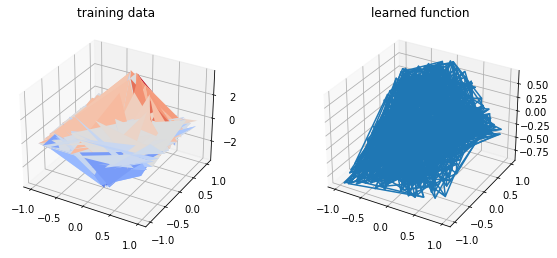

In [33]:
############################ PLOT PREDICTIONS ############################ 
n_train = Xnorm.shape[0]
n_rt = np.sqrt(n_train).astype(int)
X = np.zeros((n_rt, n_rt))
Y = np.zeros((n_rt, n_rt))
Z_true = np.zeros((n_rt, n_rt))
Z_pred = np.zeros((n_rt, n_rt))
for i in range(n_rt):
    for j in range(n_rt):
        X[i, j] = Xnorm[i * n_rt + j, 0]
        Y[i, j] = Xnorm[i * n_rt + j, 1]
        Z_true[i, j] = ynorm[i * n_rt + j]
        Z_pred[i, j] = y_pred[i * n_rt + j]

fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
cmap = plt.get_cmap('coolwarm')
ax.plot_surface(X, Y, Z_true, cmap=cmap)
ax.set_title('training data')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_wireframe(X, Y, Z_pred)
ax.set_title('learned function')
plt.show()


## Optimize with maingopy

In [34]:
# To define a model, we need to spcecialize the MAiNGOmodel class
class Model(maingopy.MAiNGOmodel):
    def __init__(self):
        maingopy.MAiNGOmodel.__init__(self)
        # Initialize feedforward neural network and load data from example csv file
        self.ffANN = maingopy.melonpy.FeedForwardNet()
        # folder where the model xml is stored
        self.path = "./data/Output/"
        # xml filename
        self.fileName= "peaks"
        # open them (define that it is an XML instead of a CSV)
        self.ffANN.load_model(self.path, self.fileName, maingopy.melonpy.XML)

    # We need to implement the get_variables functions for specifying the optimization varibles
    def get_variables(self):
        # define bounds of the original variables, so that it rescales the results fo the optimization
        # the optimization is done with the normalized version of these values
        variables = [ maingopy.OptimizationVariable(maingopy.Bounds(-3,3), maingopy.VT_CONTINUOUS, "x"),
                      maingopy.OptimizationVariable(maingopy.Bounds(-3,3), maingopy.VT_CONTINUOUS, "y") ]
        return variables

    # We need to implement the evaluate function that computes the values of the objective and constraints from the variables.
    # Note that the variables in the 'vars' argument of this function do correspond to the optimization variables defined in the get_variables function.
    # However, they are different objects for technical reasons. The only mapping we have between them is the position in the list.
    # The results of the evaluation (i.e., objective and constraint values) need to be return in an EvaluationContainer
    def evaluate(self, vars):
        x = vars[0]
        y = vars[1]
        
        # Inputs to the ANN are the variables x and y
        annInputs = [x, y]
        
        # Evaluate the network (in reduced-space)
        # This returns a list, because the output of the network may be multidimensional
        annOutputs = self.ffANN.calculate_prediction_reduced_space(annInputs)

        # Set the ANN output (only 1 in this case) as objective to be minimized
        result = maingopy.EvaluationContainer()
        result.objective = annOutputs[0]

        return result

In [35]:
# To work with the problem, we first create an instance of the model.
myModel = Model()
# We then create an instance of MAiNGO, the solver, and hand it the model.
myMAiNGO = maingopy.MAiNGO(myModel)

In [36]:
# We can have MAiNGO read a settings file:
fileName = ""
myMAiNGO.read_settings(fileName) # If fileName is empty, MAiNGO will attempt to open MAiNGOSettings.txt
myMAiNGO.set_log_file_name(".logs/my_log_file.log")
myMAiNGO.set_option("writeCsv", True)
myMAiNGO.set_iterations_csv_file_name(".logs/iterations.csv")
myMAiNGO.set_solution_and_statistics_csv_file_name(".logs/solution_and_statistics.csv")

In [37]:
myMAiNGO.write_model_to_file_in_other_language(writingLanguage=maingopy.LANG_GAMS, fileName="./logs(my_problem_file_MAiNGO.gms", solverName="SCIP", writeRelaxationOnly=False)

In [38]:
# Finally, we call the solve routine to solve the problem.
maingoStatus = myMAiNGO.solve()
print(maingoStatus)

RETCODE.GLOBALLY_OPTIMAL


In [39]:
dir(myMAiNGO)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'evaluate_additional_outputs_at_point',
 'evaluate_additional_outputs_at_solution_point',
 'evaluate_model_at_point',
 'evaluate_model_at_solution_point',
 'get_LBP_count',
 'get_UBP_count',
 'get_cpu_solution_time',
 'get_final_LBD',
 'get_final_abs_gap',
 'get_final_rel_gap',
 'get_iterations',
 'get_max_nodes_in_memory',
 'get_objective_value',
 'get_solution_point',
 'get_status',
 'get_wallclock_solution_time',
 'read_settings',
 'set_iterations_csv_file_name',
 'set_json_file_name',
 'set_log_file_name',
 'set_model',
 'set_option',
 'set_result_file_name',
 'set_solution_and_statistics_csv_file_name',
 'solve',
 'write_model_to_file_in_other_l

In [40]:
myMAiNGO.get_solution_point()

[-3.0, -3.0]

In [41]:
myMAiNGO.get_objective_value()

-1.5587385835855327

In [42]:
myMAiNGO.get_status()

<RETCODE.GLOBALLY_OPTIMAL: 0>

In [43]:
myMAiNGO.get_cpu_solution_time()

0.062000000005355105

In [44]:
maingopy.Bounds(-3,3)

In [45]:
myMAiNGO.evaluate_model_at_point(np.array([0.228, -1.626]))

([-0.5375481046174451], True)

In [49]:
model.predict(np.array([[-1,-1]]))

array([[-0.9721647]], dtype=float32)

In [50]:
model.predict(np.array([[0, -0.5]]))

array([[-0.4132011]], dtype=float32)

In [52]:
np.array([[0.228, -1.626]])

TypeError: 'numpy.float64' object does not support item assignment